# Phenotyping (Radiomic Phenotypes in Lung Cancer)

# Dataset: Tumor Features

In [10]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import chi2_contingency

excel_path = "data/elife-23421-fig2-data2.xlsx"  
excel_file = pd.ExcelFile(excel_path)

# Load data
imaging_df = excel_file.parse('imaging').rename(columns={"Unnamed: 0": "SampleID"})
clinical_df = excel_file.parse('clinical').rename(columns={"Unnamed: 0": "SampleID"})
merged_df = pd.merge(imaging_df, clinical_df, on="SampleID", how="inner")

# Radiomic feature columns
feature_cols = [col for col in imaging_df.columns if col != "SampleID"]
radiomic_data = merged_df[feature_cols].select_dtypes(include=[np.number])
radiomic_data = radiomic_data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
radiomic_data_std = (radiomic_data - radiomic_data.mean()) / radiomic_data.std()
radiomic_data_std.index = merged_df['SampleID']

In [11]:
merged_df

,SampleID,radiomics.Structure.Name,radiomics.Radiomics.Function,radiomics.Mapped.Structure.Name,imaging.radiomics.GLCM_autocorr,imaging.radiomics.GLCM_clusProm,imaging.radiomics.GLCM_clusShade,imaging.radiomics.GLCM_clusTend,imaging.radiomics.GLCM_contrast,imaging.radiomics.GLCM_correl1,...,imaging.radiomics.Wavelet_LLL_stats_skewness,imaging.radiomics.Wavelet_LLL_stats_std,imaging.radiomics.Wavelet_LLL_stats_totalenergy,imaging.radiomics.Wavelet_LLL_stats_uniformity,imaging.radiomics.Wavelet_LLL_stats_var,surv.clinical.Event,surv.clinical.Time.Months,clinical.histology.curated,clinical.combined.stage.curated,clinical.gender.curated
0,LUNG3-64,binarystrucutre,extractRadiomicsCT_resampled,GTV,1015.604377,1.728441e+06,-16203.786420,995.351478,22.221434,0.957409,...,0.031798,1304.624058,2.093502e+08,0.047220,1.702044e+09,1,32.843836,squamous,II,F
1,LUNG3-37,binarystrucutre,extractRadiomicsCT_resampled,GTV,921.867862,6.464357e+04,-1855.872326,111.303433,24.812007,0.630987,...,-1.232774,497.655023,2.372606e+07,0.091541,2.476605e+08,0,57.205479,squamous,I,M
2,LUNG3-35,binarystrucutre,extractRadiomicsCT_resampled,GTV,632.293653,2.927069e+04,-1068.132061,84.292617,7.278293,0.839872,...,-1.243821,359.149777,3.164909e+08,0.144030,1.289886e+05,1,14.400000,adeno,III,M
3,LUNG3-11,binarystrucutre,extractRadiomicsCT_resampled,GTV,768.887796,1.016742e+04,-348.622125,29.055416,6.021883,0.658310,...,-2.325833,218.932372,7.121297e+08,0.240815,4.793138e+04,0,67.068493,squamous,I,M
4,LUNG3-08,binarystrucutre,extractRadiomicsCT_resampled,GTV,131.834572,3.611580e+01,-2.013109,2.503468,1.033765,0.411724,...,-1.020618,69.813296,1.908266e+08,0.360381,4.873896e+03,1,51.156164,adeno,I,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,LUNG3-87,binarystrucutre,extractRadiomicsCT_resampled,GTV,603.054548,3.314669e+05,1834.022542,488.061895,9.442247,0.967033,...,0.147291,792.489235,2.985662e+08,0.091199,6.280392e+05,1,82.783562,squamous,I,M
84,LUNG3-38,binarystrucutre,extractRadiomicsCT_resampled,GTV,1726.367922,4.040858e+04,-874.026124,31.988221,7.225593,0.632259,...,-4.068370,267.867124,4.396834e+08,0.189860,7.175280e+04,1,17.293151,squamous,II,M
85,LUNG3-61,binarystrucutre,extractRadiomicsCT_resampled,GTV,473.814975,2.669862e+04,-868.125572,98.751127,5.111226,0.902248,...,-0.821885,373.004255,3.136865e+08,0.095700,1.391322e+05,1,7.002740,squamous,II,M
86,LUNG3-59,binarystrucutre,extractRadiomicsCT_resampled,GTV,404.275573,2.867433e+04,-707.032249,93.849341,22.308018,0.618446,...,-0.622212,429.690726,5.023587e+09,0.049898,1.846341e+05,0,91.594521,other,I,F


In [12]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from lifelines.statistics import logrank_test

pca = PCA(n_components=5)
radiomic_pca = pca.fit_transform(radiomic_data_std)

# KMeans clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(radiomic_pca)

merged_df['Phenotype_KMeans'] = ['Phenotyping Group 1' if c == 0 else 'Phenotyping Group 2' for c in cluster_labels]

surv_df = merged_df[['Phenotype_KMeans', 'surv.clinical.Time.Months', 'surv.clinical.Event']].dropna()
group1 = surv_df[surv_df['Phenotype_KMeans'] == 'Phenotyping Group 1']
group2 = surv_df[surv_df['Phenotype_KMeans'] == 'Phenotyping Group 2']

result = logrank_test(group1['surv.clinical.Time.Months'], group2['surv.clinical.Time.Months'],
                      event_observed_A=group1['surv.clinical.Event'],
                      event_observed_B=group2['surv.clinical.Event'])

print(f"Log-rank test p-value (KMeans Phenotypes): {result.p_value}")

C:\Users\semon\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\semon\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Log-rank test p-value (KMeans Phenotypes): 0.03294610368565913


In [13]:
feature_cols = [col for col in merged_df.columns if col.startswith("imaging.")]
radiomic_data_full = merged_df[feature_cols].select_dtypes(include=[np.number])

# standardize the data
radiomic_data_full = radiomic_data_full.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
radiomic_data_std_full = (radiomic_data_full - radiomic_data_full.mean()) / radiomic_data_full.std()


# Clustering

C:\Users\semon\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\semon\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


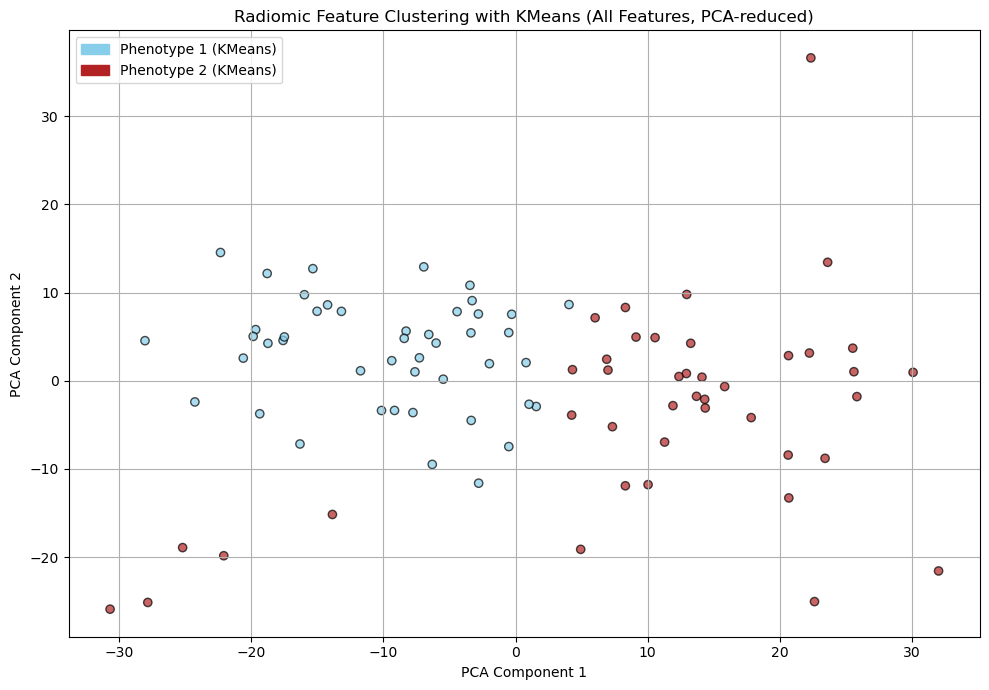

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


pca_2d = PCA(n_components=2)
radiomic_pca_2d = pca_2d.fit_transform(radiomic_data_std_full)

# KMeans clustering 
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(radiomic_pca_2d)


merged_df['Phenotype_KMeans'] = ['Phenotype 1' if c == 0 else 'Phenotype 2' for c in clusters_kmeans]


plt.figure(figsize=(10, 7))
colors = ['skyblue' if c == 0 else 'firebrick' for c in clusters_kmeans]
plt.scatter(radiomic_pca_2d[:, 0], radiomic_pca_2d[:, 1], c=colors, alpha=0.7, edgecolor='k')

plt.title('Radiomic Feature Clustering with KMeans (All Features, PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
phenotype_patch = [mpatches.Patch(color='skyblue', label='Phenotype 1 (KMeans)'),
                   mpatches.Patch(color='firebrick', label='Phenotype 2 (KMeans)')]
plt.legend(handles=phenotype_patch)
plt.grid(True)
plt.tight_layout()
plt.show()


# Cluster with hierarchical

# Full Variables

C:\Users\semon\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\semon\AppData\Local\Temp\ipykernel_20956\2674055344.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


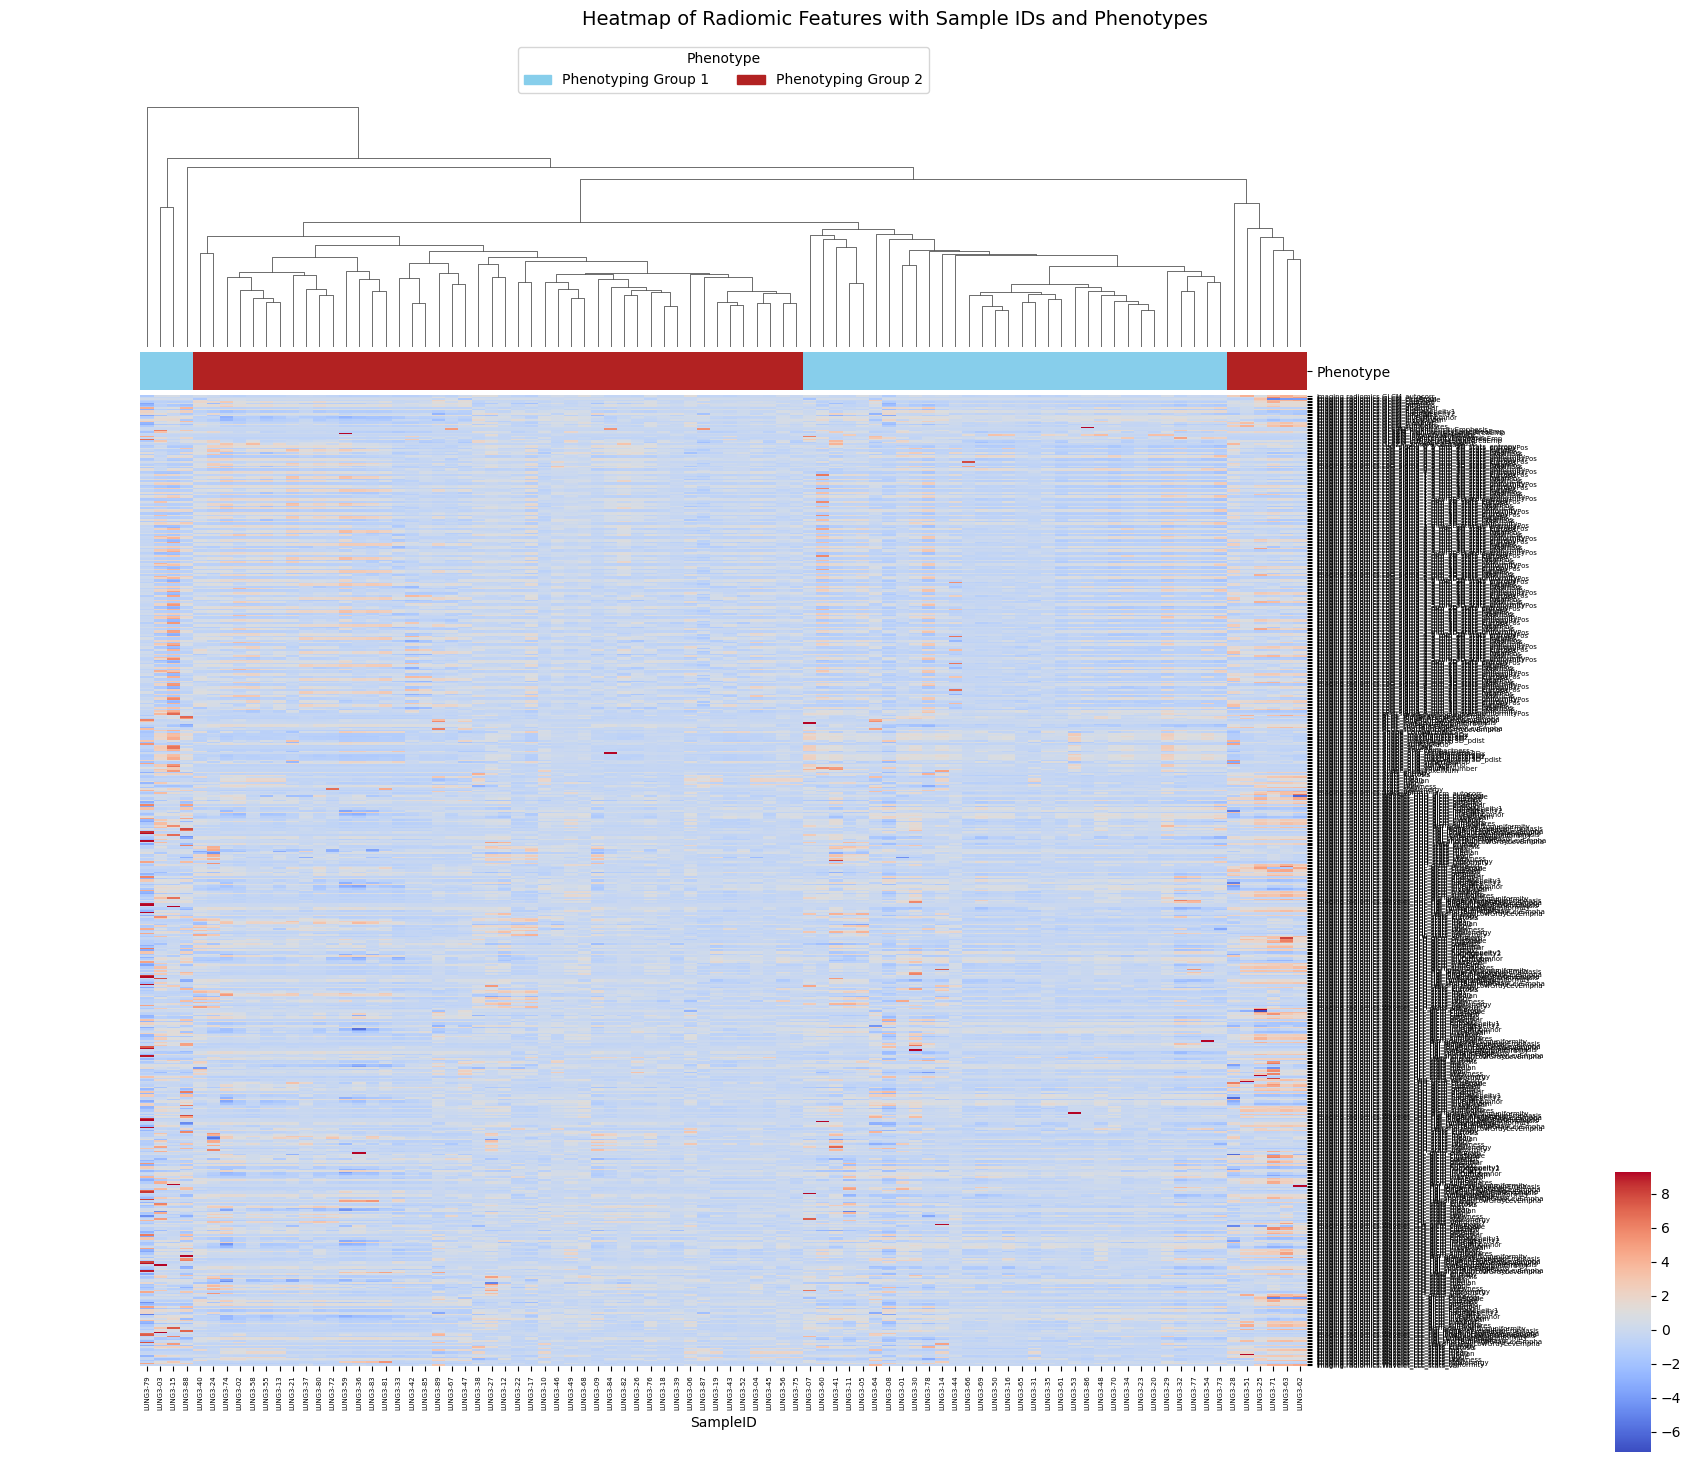

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


radiomic_data_std_full.index = merged_df['SampleID']


Z = linkage(radiomic_data_std_full, method='ward')
cluster_labels = fcluster(Z, 2, criterion='maxclust')
merged_df['Phenotype'] = ['Phenotype 1' if c == 1 else 'Phenotype 2' for c in cluster_labels]

phenotype_colors = merged_df.set_index('SampleID').loc[radiomic_data_std_full.index]['Phenotype'].map({
    'Phenotype 1': 'skyblue',
    'Phenotype 2': 'firebrick'
})

# Create the full vertical heatmap
g = sns.clustermap(
    radiomic_data_std_full.T,
    col_cluster=True,
    row_cluster=False,
    col_colors=phenotype_colors,
    figsize=(18, 14),
    cmap='coolwarm',
    xticklabels=radiomic_data_std_full.index.tolist(),
    yticklabels=radiomic_data_std_full.columns.tolist(),
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0.9, 0.02, 0.02, 0.2)
)

# Rotate labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=5)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=5)

# Add legend
phenotype_patches = [
    mpatches.Patch(color='skyblue', label='Phenotyping Group 1'),
    mpatches.Patch(color='firebrick', label='Phenotyping Group 2')
]
g.ax_col_dendrogram.legend(handles=phenotype_patches, title='Phenotype', loc='center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.suptitle('Heatmap of Radiomic Features with Sample IDs and Phenotypes', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# Sampled Varaibles/ Features (For better visualization)

C:\Users\semon\AppData\Local\Temp\ipykernel_20956\1192357646.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


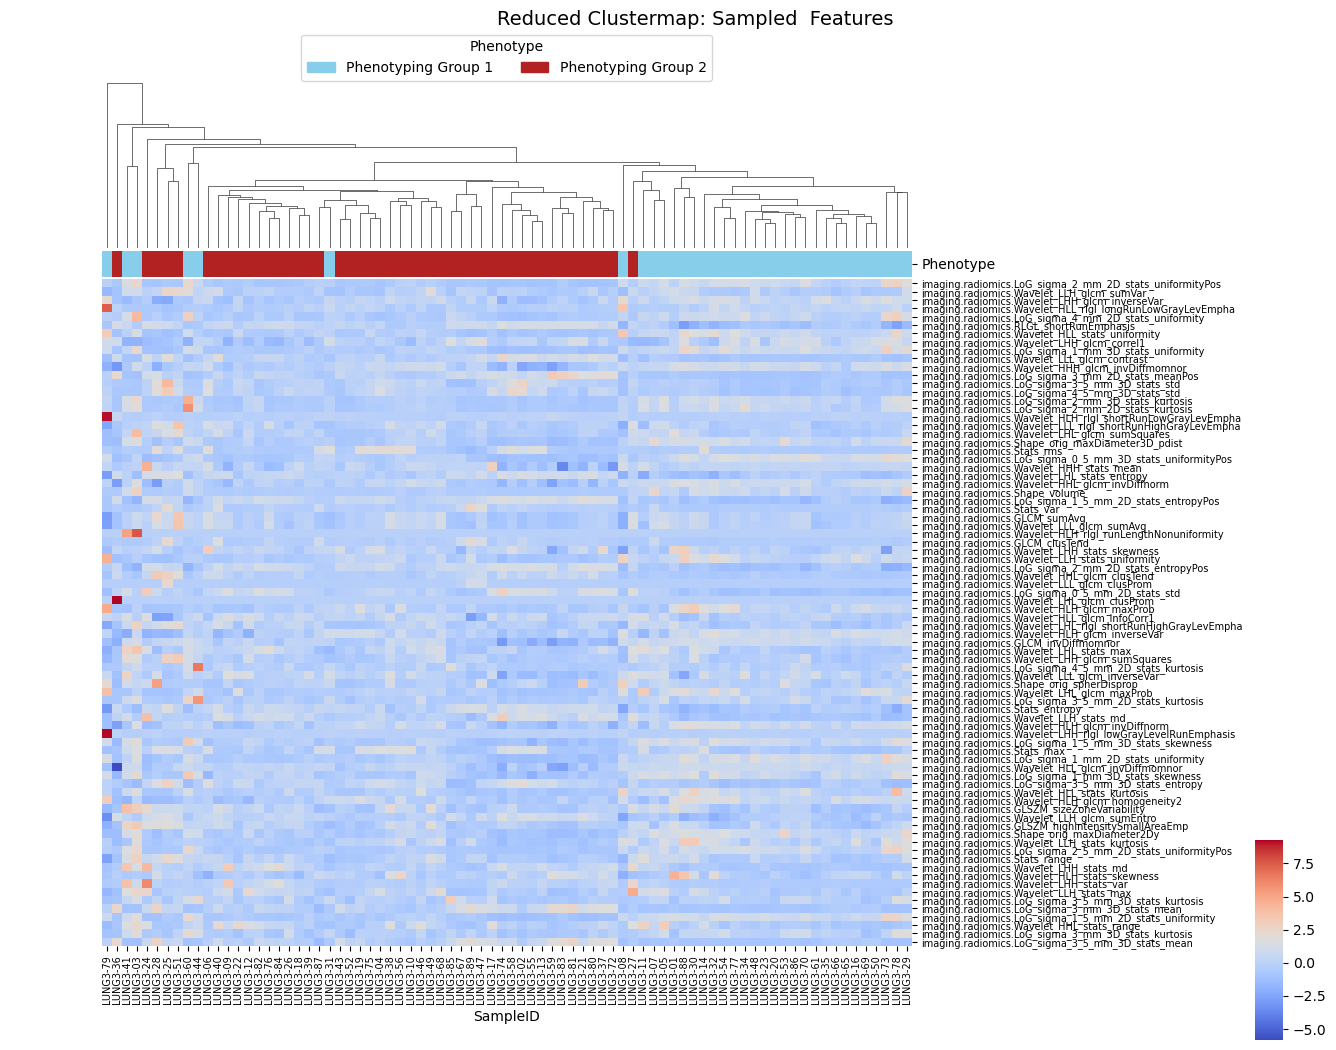

In [20]:
sampled_features = np.random.choice(radiomic_data_std_full.columns, size=80, replace=False)
sampled_patients = np.random.choice(radiomic_data_std_full.index, size=80, replace=False)

# Subset the data matrix
reduced_matrix = radiomic_data_std_full.loc[sampled_patients, sampled_features]

phenotype_colors_subset = merged_df.set_index('SampleID').loc[sampled_patients]['Phenotype'].map({
    'Phenotype 1': 'skyblue',
    'Phenotype 2': 'firebrick'
})

# Create the reduced clustermap
g = sns.clustermap(
    reduced_matrix.T,
    col_cluster=True,
    row_cluster=False,
    col_colors=phenotype_colors_subset,
    figsize=(14, 10),
    cmap='coolwarm',
    xticklabels=True,
    yticklabels=True,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0.9, 0.02, 0.02, 0.2)
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=7)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=7)

# Add legend
phenotype_patches = [
    mpatches.Patch(color='skyblue', label='Phenotyping Group 1'),
    mpatches.Patch(color='firebrick', label='Phenotyping Group 2')
]
g.ax_col_dendrogram.legend(handles=phenotype_patches, title='Phenotype', loc='center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.suptitle('Reduced Clustermap: Sampled  Features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


# Survival Analysis

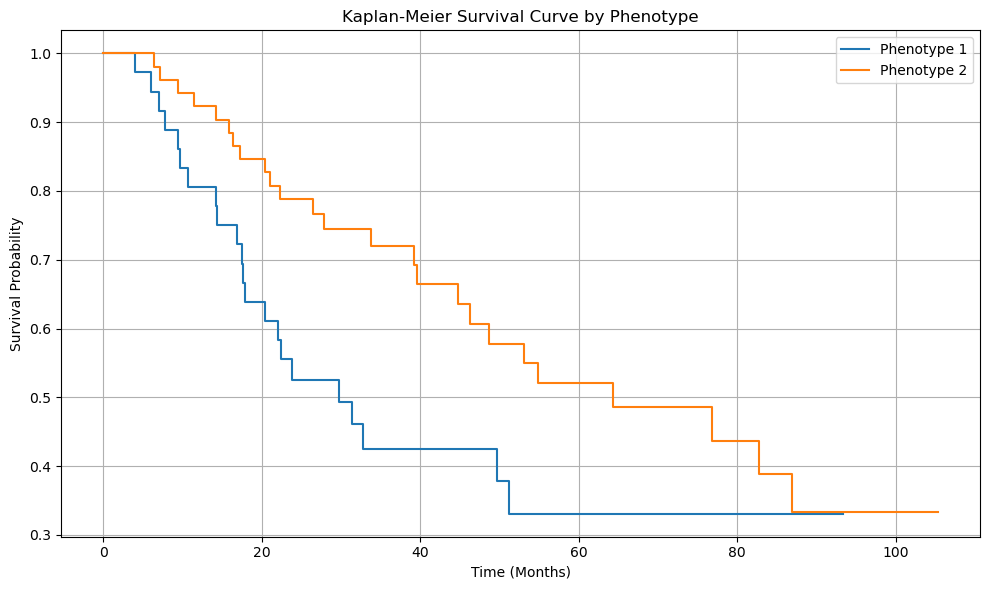

In [23]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Filter survival data
survival_df_pheno = merged_df[['Phenotype', 'surv.clinical.Time.Months', 'surv.clinical.Event']].dropna()

kmf = KaplanMeierFitter()

# Plot curves
plt.figure(figsize=(10, 6))
for phenotype in survival_df_pheno['Phenotype'].unique():
    group = survival_df_pheno[survival_df_pheno['Phenotype'] == phenotype]
    kmf.fit(group['surv.clinical.Time.Months'], event_observed=group['surv.clinical.Event'], label=phenotype)
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curve by Phenotype")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
from lifelines.statistics import logrank_test

group1 = survival_df_pheno[survival_df_pheno['Phenotype'] == 'Phenotype 1']
group2 = survival_df_pheno[survival_df_pheno['Phenotype'] == 'Phenotype 2']

result = logrank_test(
    group1['surv.clinical.Time.Months'],
    group2['surv.clinical.Time.Months'],
    event_observed_A=group1['surv.clinical.Event'],
    event_observed_B=group2['surv.clinical.Event']
)

print(f"Log-rank p-value: {result.p_value}")


Log-rank p-value: 0.059108382604382066
